### Forecasting Models on КРС 

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



#### Data preparation

In [39]:
df = pd.read_excel("Датасет по КРС.xlsx")
df.head(5)

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194


In [40]:
df_akmola = df[df['Регион'] == 'АКМОЛИНСКАЯ ОБЛАСТЬ']
df_akmola.head()

,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194


In [41]:
df_akmola = df_akmola.rename(columns={'КРС': 'Объем убоя: КРС'})
df_akmola.head()

,Регион,Период,Объем убоя: КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194


### EDA

In [42]:
df_akmola.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Регион           120 non-null    object 
 1   Период           120 non-null    object 
 2   Объем убоя: КРС  120 non-null    float64
 3   Осадки           120 non-null    float64
 4   Поголовье: КРС   120 non-null    float64
 5   Температура      120 non-null    float64
dtypes: float64(4), object(2)
memory usage: 6.6+ KB


In [43]:
df_akmola.isna().sum()

Регион             0
Период             0
Объем убоя: КРС    0
Осадки             0
Поголовье: КРС     0
Температура        0
dtype: int64

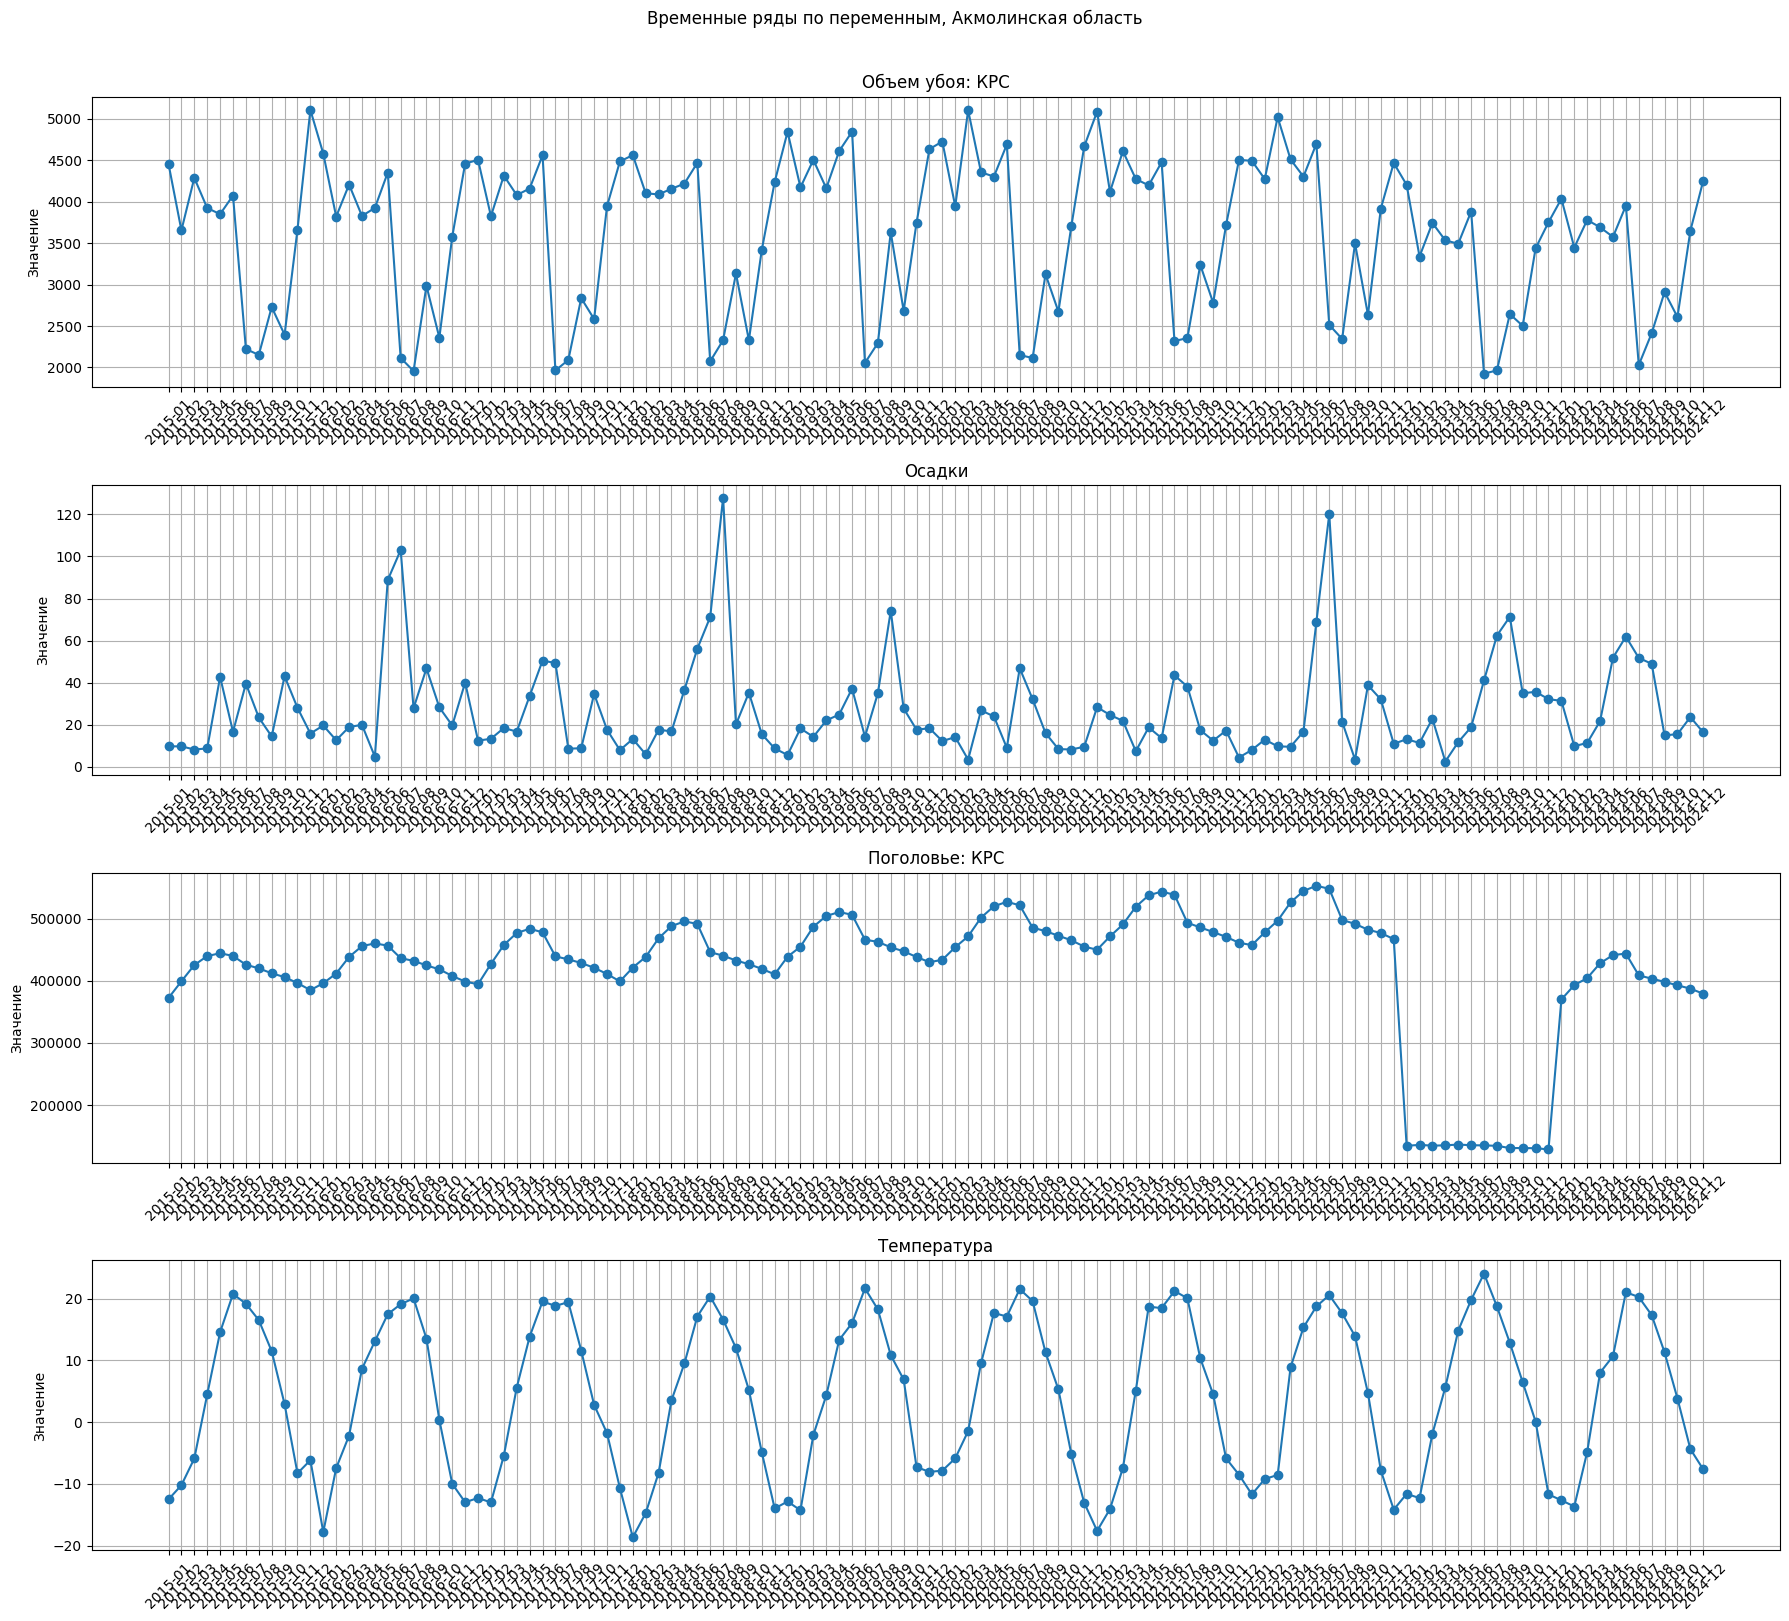

In [44]:
# Plot each variable in its own subplot
value_cols = [col for col in df_akmola.columns if col not in ["Период", "Регион"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_akmola["Период"], df_akmola[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45)

plt.suptitle("Временные ряды по переменным, Акмолинская область", y=1.01)
plt.tight_layout()
plt.show()


In [55]:
# # Add lag features to your dataframe
# for lag in range(1, 13):  # t-1 to t-4
#     df_akmola[f"КРС_t-{lag}"] = df_akmola["Объем убоя: КРС"].shift(lag)

# # Drop NA rows (due to lag creation)
# df_akmola_lagged = df_akmola.dropna().copy()
# df_akmola_lagged

# Create lags (t-6 to t+6) for the target variable
for lag in range(-6, 7):
    if lag < 0:
        df_akmola[f"КРС_t+{abs(lag)}"] = df_akmola["Объем убоя: КРС"].shift(lag)  # lead
    elif lag > 0:
        df_akmola[f"КРС_t-{lag}"] = df_akmola["Объем убоя: КРС"].shift(lag)

# Drop NA rows caused by shifting
df_akmola_lagged = df_akmola.dropna().copy()
df_akmola_lagged = df_akmola_lagged[['Регион', 'Период', 'Осадки', 'Поголовье: КРС',
       'Температура', 'КРС_t-6', 'КРС_t-5', 'КРС_t-4', 'КРС_t-3', 'КРС_t-2',
       'КРС_t-1', 'Объем убоя: КРС', 'КРС_t+1', 'КРС_t+2', 'КРС_t+3', 'КРС_t+4', 'КРС_t+5', 'КРС_t+6']]
df_akmola_lagged.head()


,Регион,Период,Осадки,Поголовье: КРС,Температура,КРС_t-6,КРС_t-5,КРС_t-4,КРС_t-3,КРС_t-2,КРС_t-1,Объем убоя: КРС,КРС_t+1,КРС_t+2,КРС_t+3,КРС_t+4,КРС_t+5,КРС_t+6
6,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-07,39.6,426134.0,19.180645,4455.35,3654.20,4287.08,3923.21,3849.70,4074.13,2221.96,2151.76,2728.61,2395.25,3662.75,5106.13,4579.64
7,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-08,23.5,420244.0,16.529032,3654.20,4287.08,3923.21,3849.70,4074.13,2221.96,2151.76,2728.61,2395.25,3662.75,5106.13,4579.64,3819.89
8,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-09,14.5,412301.0,11.496667,4287.08,3923.21,3849.70,4074.13,2221.96,2151.76,2728.61,2395.25,3662.75,5106.13,4579.64,3819.89,4206.27
9,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-10,43.1,406176.0,2.925806,3923.21,3849.70,4074.13,2221.96,2151.76,2728.61,2395.25,3662.75,5106.13,4579.64,3819.89,4206.27,3828.08
10,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-11,28.1,396512.0,-8.270000,3849.70,4074.13,2221.96,2151.76,2728.61,2395.25,3662.75,5106.13,4579.64,3819.89,4206.27,3828.08,3924.54


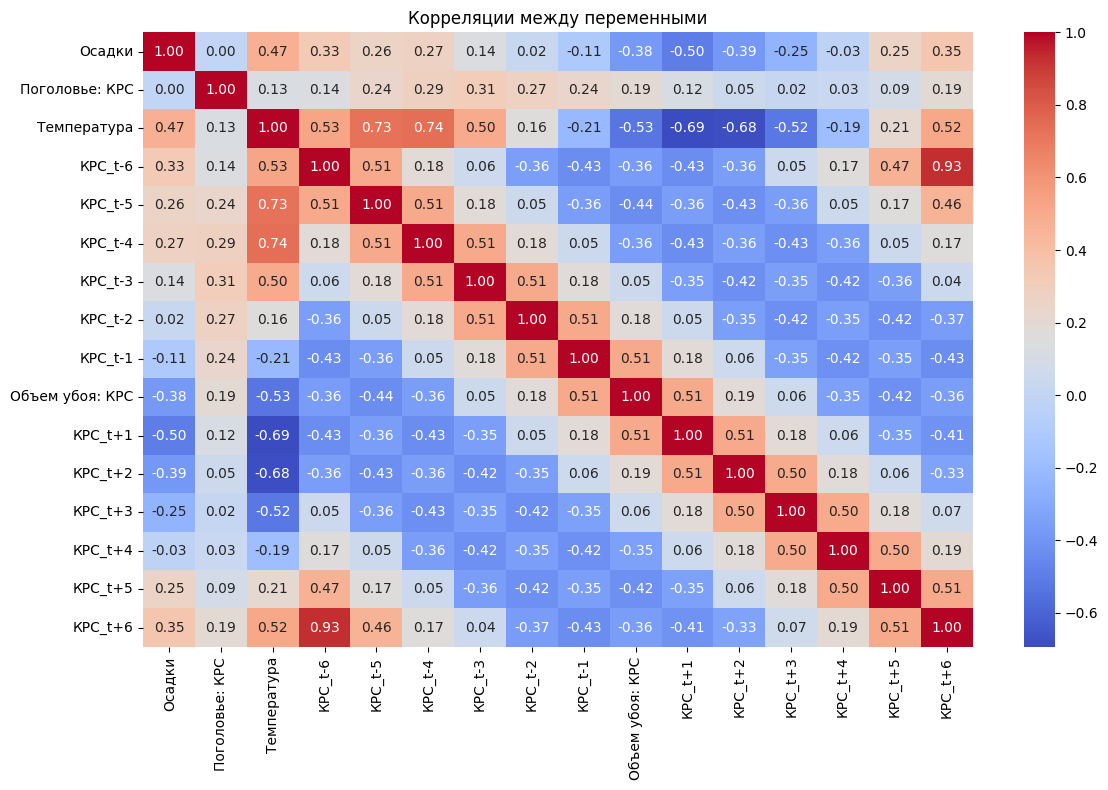

In [56]:
df_corr = df_akmola_lagged[[col for col in df_akmola_lagged.columns if col not in ["Регион", "Период"]]].dropna()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными")
plt.tight_layout()
plt.show()

* Сильная позитивная корреляция (0.93) между показателями объема убоя с лагом в +6 и -6 месяцев, что указывает на (годовой) сезонный характер динамики показателя;
* Умеренная позитивная корреляция (~0.50) между показателями объема убоя за все соседствующие временные периоды: между t0 и t+1, t0 и t-1, t+3 и t+2, t+3 и t+4 и так далее. Это свидетельствует о наличии автокорреляции в данных: значения показателя в текущем месяце частично объясняются значениями в соседних месяцах. Это типичный признак временных рядов, особенно в аграрной статистике, где производственные процессы имеют инерционный характер. Это также означает, что модели авторегрессии (AR, ARIMA, SARIMA) могут хорошо работать на этих данных, так как текущие значения "похожи" на недавние.
* Корреляция между значениями текущего месяца и соседствующих месяцев ослабевает после 3-х месяцев, что может быть следствием ежеквартальной статистической отчетности по продукции КФХ и населения (большинство) и возможной декомпозиции квартальных данных на соответствующие месяцы.
Корреляция между значениями объема убоя в текущем и соседствующих месяцах заметно ослабевает после лагов ±3 месяцев. Это может быть связано с тем, что основной объём данных формируется за счёт отчетности крестьянских/фермерских хозяйств и хозяйств населения, которые сдают отчетность ежеквартально. В результате, месячные значения могут быть получены путём декомпозиции квартальных показателей, что сглаживает внутриквартальные различия, но снижает связь между кварталами.
* Температура и осадки умеренно негативно коррелируют с показателями обема убоя с лагом до 3-х месяцев (с постепенным снижением силы взаимосвязи). 
* Между показателями объема убоя и поголовья в рамках текущего и следующего месяца отмечается незначительная позитивная корреляция (0.19 и 0.12). При этом установлена незначительно-умеренная позитивная взаимосвязь (0.20-0.30) между показателями объема убоя за предыдущие месяцы (до 5 месяцев назад) и поголовья. 

**ДОБАВИТЬ ЕЩЕ НЕБОЛЬШИЕ ВЫВОДЫ**

In [ ]:
X_vif = add_constant(df_corr[[i for i in df_corr.columns if i != "Объем убоя: КРС"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data

,Variable,VIF
0,const,653.417096
1,Осадки,1.559632
2,Поголовье: КРС,2.846363
3,Температура,15.053594
4,КРС_t-6,8.591529
5,КРС_t-5,5.066881
6,КРС_t-4,4.743597
7,КРС_t-3,4.232776
8,КРС_t-2,3.746488
9,КРС_t-1,3.710058


### Multivariate Regression

#### check statistical significance

In [ ]:
y = df_akmola["КРС"]
X = df_akmola[["Поголовье: КРС", "Температура", "Осадки"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Print model summary
print(f"\n📍 Регион: {df_akmola.loc[0]['Регион']}")
print(model.summary())

#     # ✅ Collect results
#     for var in model.params.index:
#         results_list.append({
#             "Регион": region,
#             "Переменная": var,
#             "Коэффициент": model.params[var],
#             "p-value": model.pvalues[var],
#             "R-квадрат": model.rsquared
#         })

# # Convert to DataFrame
# results_df = pd.DataFrame(results_list)

# # Export to Excel
# # results_df.to_excel("krs_linear_regression_results.xlsx", index=False)

# print("\n Готово! Результаты экспортированы в 'krs_linear_regression_results.xlsx'")


#### forecast using MLR

In [ ]:
# Forecasting horizon
forecast_horizon = 3

# Container for summary results
results = []

# Loop through each region
for region in df_model["Регион"].unique():
    if region == "РЕСПУБЛИКА КАЗАХСТАН":
        continue  # ⛔ skip this region
    df_r = df_model[df_model["Регион"] == region].sort_values("Период")

    if df_r.shape[0] < forecast_horizon + 12:
        continue  # skip if not enough data

    # Train-test split
    df_train = df_r.iloc[:-forecast_horizon]
    df_test = df_r.iloc[-forecast_horizon:]

    X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
    y_train = df_train["КРС"]
    X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
    y_test = df_test["КРС"]

    # Fit model
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (abs((y_test - y_pred) / y_test).mean()) * 100

    results.append({
        "Регион": region,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R² (Train)": model.score(X_train, y_train)
    })

# Save results
results_df = pd.DataFrame(results)
# results_df.to_excel("mlr_forecast_evaluation_by_region.xlsx", index=False)

results_df


In [ ]:
# Calculate and print mean metrics
mean_mape = results_df["MAPE (%)"].mean()
mean_rmse = results_df["RMSE"].mean()
mean_mae = results_df["MAE"].mean()

print(f"Средние метрики по регионам:")
print(f"Средний MAPE: {mean_mape:.2f}%")
print(f"Средний RMSE: {mean_rmse:.2f}")
print(f"Средний MAE: {mean_mae:.2f}")

#### regression for Kazakhstan - Поголовье not statistically significant

In [ ]:
df_kazakhstan = df_model[df_model['Регион'] == 'РЕСПУБЛИКА КАЗАХСТАН'][["КРС", "Поголовье: КРС"]].dropna()
y = df_kazakhstan["КРС"]
X = df_kazakhstan[["Поголовье: КРС"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Print model summary
print("Регион: РЕСПУБЛИКА КАЗАХСТАН")
print(model.summary())

In [ ]:
# from sklearn.linear_model import Ridge

# # Forecasting horizon
# forecast_horizon = 3

# # Container for summary results
# results = []

# # Loop through each region
# for region in df_model["Регион"].unique():
#     if region == "РЕСПУБЛИКА КАЗАХСТАН":
#         continue  # ⛔ skip this region
#     df_r = df_model[df_model["Регион"] == region].sort_values("Период")

#     if df_r.shape[0] < forecast_horizon + 12:
#         continue  # skip if not enough data

#     # Train-test split
#     df_train = df_r.iloc[:-forecast_horizon]
#     df_test = df_r.iloc[-forecast_horizon:]

#     X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_train = df_train["КРС"]
#     X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_test = df_test["КРС"]

#     # Fit model
#     model = Ridge(alpha=1.0).fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     mape = (abs((y_test - y_pred) / y_test).mean()) * 100

#     results.append({
#         "Регион": region,
#         "RMSE": rmse,
#         "MAE": mae,
#         "MAPE (%)": mape,
#         "R² (Train)": model.score(X_train, y_train)
#     })

#     # Plot actual vs forecast
#     plt.figure(figsize=(6, 3))
#     plt.plot(df_test["Период"], y_test, marker="o", label="Факт")
#     plt.plot(df_test["Период"], y_pred, marker="s", label="Прогноз")
#     plt.title(f"{region} — Прогноз объема КРС на {forecast_horizon} месяца")
#     plt.xlabel("Месяц")
#     plt.ylabel("Объем КРС")
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Save results
# results_df = pd.DataFrame(results)
# results_df.to_excel("ridge_forecast_evaluation_by_region.xlsx", index=False)

# print("✅ Готово! Метрики и графики прогноза рассчитаны.")


In [ ]:
# # Forecasting horizon
# forecast_horizon = 12

# # Container for summary results
# results = []

# # Loop through each region
# for region in df_model["Регион"].unique():
#     if region == "РЕСПУБЛИКА КАЗАХСТАН":
#         continue  # ⛔ skip this region
#     df_r = df_model[df_model["Регион"] == region].sort_values("Период")

#     if df_r.shape[0] < forecast_horizon + 12:
#         continue  # skip if not enough data

#     # Train-test split
#     df_train = df_r.iloc[:-forecast_horizon]
#     df_test = df_r.iloc[-forecast_horizon:]

#     X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_train = df_train["КРС"]
#     X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_test = df_test["КРС"]

#     # Fit model
#     model = LinearRegression().fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     mape = (abs((y_test - y_pred) / y_test).mean()) * 100

#     results.append({
#         "Регион": region,
#         "RMSE": rmse,
#         "MAE": mae,
#         "MAPE (%)": mape,
#         "R² (Train)": model.score(X_train, y_train)
#     })

#     # 🟦 Optional: Plot actual vs forecast
#     plt.figure(figsize=(8, 4))
#     plt.plot(df_test["Период"], y_test, marker="o", label="Факт")
#     plt.plot(df_test["Период"], y_pred, marker="s", label="Прогноз")
#     plt.title(f"{region} — Прогноз объема КРС на {forecast_horizon} месяца")
#     plt.xlabel("Месяц")
#     plt.ylabel("Объем КРС")
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Save results
# results_df = pd.DataFrame(results)
# results_df.to_excel("mlr_forecast_evaluation_by_region_12m.xlsx", index=False)

# print("✅ Готово! Метрики и графики прогноза рассчитаны.")


In [ ]:
# def sliding_window_evaluation(df_r, forecast_horizon=3, window_count=9):
#     metrics = []

#     # Ensure sorted by time
#     df_r = df_r.sort_values("Период").reset_index(drop=True)

#     for i in range(window_count):
#         # Define train and test split
#         train_end = i + 12  # require 12+ months for training
#         test_start = train_end
#         test_end = test_start + forecast_horizon

#         if test_end > len(df_r):
#             break

#         df_train = df_r.iloc[:train_end]
#         df_test = df_r.iloc[test_start:test_end]

#         X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
#         y_train = df_train["КРС"]
#         X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
#         y_test = df_test["КРС"]

#         # Fit model
#         model = LinearRegression().fit(X_train, y_train)
#         y_pred = model.predict(X_test)

#         # Calculate metrics
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         mae = mean_absolute_error(y_test, y_pred)
#         mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

#         metrics.append({"RMSE": rmse, "MAE": mae, "MAPE": mape})

#     # Aggregate metrics over all sliding windows
#     return pd.DataFrame(metrics).mean().to_dict()

# results = []

# for region in df_model["Регион"].unique():
#     if region == "РЕСПУБЛИКА КАЗАХСТАН":
#         continue  # Optional: exclude a region

#     df_r = df_model[df_model["Регион"] == region][["Период", "КРС", "Поголовье: КРС", "Температура", "Осадки"]].dropna()

#     if df_r.shape[0] < 24:
#         continue  # need enough data for multiple windows

#     metrics = sliding_window_evaluation(df_r)

#     results.append({
#         "Регион": region,
#         "Avg RMSE": metrics["RMSE"],
#         "Avg MAE": metrics["MAE"],
#         "Avg MAPE (%)": metrics["MAPE"]
#     })

# # Save result
# results_df = pd.DataFrame(results)
# results_df.to_excel("sliding_window_forecast_evaluation.xlsx", index=False)

# print("✅ Готово! Средние метрики по скользящим окнам сохранены.")



### Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
# Container for forecast evaluation results
results = []

# Loop over each region
for region in df_model["Регион"].unique():
    df_r = df_model[df_model["Регион"] == region].sort_values("Период")
    y = df_r["КРС"].reset_index(drop=True)

    if y.isna().sum() > 0 or len(y) < 24:  # Need at least 2 full seasons
        continue

    # Split data
    test_size = 3
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    try:
        # Auto SARIMA model selection
        model = auto_arima(
            y_train,
            seasonal=True,        # Enable SARIMA
            m=12,                 # Season length (12 months)
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        # Forecast
        forecast = model.predict(n_periods=test_size)

        # Evaluation
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Регион": region,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape
        })

        # Plot actual vs forecast
        plt.figure(figsize=(8, 4))
        plt.plot(y.index, y, color="lightgray", label="Все данные")
        plt.plot(y_test.index, y_test, marker="o", color="black", label="Факт (тест)")
        plt.plot(y_test.index, forecast, marker="s", linestyle="--", color="red", label="Прогноз")
        plt.axvline(len(y_train) - 1, color="gray", linestyle="--", label="Граница Train/Test")
        plt.title(f"{region} — SARIMA{model.order}x{model.seasonal_order} Прогноз КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в {region}: {e}")

# Save results to Excel
results_df = pd.DataFrame(results)
results_df
# results_df.to_excel("sarima_forecast_evaluation_all_regions.xlsx", index=False)


In [ ]:
# Calculate and print mean metrics
mean_mape = results_df["MAPE (%)"].mean()
mean_rmse = results_df["RMSE"].mean()
mean_mae = results_df["MAE"].mean()

print(f"Средние метрики по регионам:")
print(f"Средний MAPE: {mean_mape:.2f}%")
print(f"Средний RMSE: {mean_rmse:.2f}")
print(f"Средний MAE: {mean_mae:.2f}")

In [ ]:
# Step 1: Select one region's time series
region = "АКМОЛИНСКАЯ ОБЛАСТЬ"
df_r = df_model[df_model["Регион"] == region].sort_values("Период")
y = df_r["КРС"].reset_index(drop=True)

# Step 2: Check stationarity (ADF test)
result = adfuller(y)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("❌ Non-stationary — differencing needed.")
else:
    print("✅ Stationary")



In [ ]:
# Step 3: (If needed) difference the series
y_diff = y.diff().dropna()

In [ ]:
# Step 4: Fit ARIMA model (p,d,q) — try (1,1,1) to start
model = ARIMA(y, order=(1,1,1))  # (p=1, d=1, q=1) — adjust based on AIC later
model_fit = model.fit()

# Step 5: Forecast next 3 months
forecast = model_fit.forecast(steps=3)
print("🔮 Forecast for next 3 months:")
print(forecast)

# Step 6: Plot
plt.figure(figsize=(10,5))
plt.plot(y, label="Actual")
plt.plot(np.arange(len(y), len(y)+3), forecast, label="Forecast", marker='o')
plt.title(f"ARIMA Forecast — {region}")
plt.legend()
plt.grid(True)
plt.show()